In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import get_data
import plotly.express as px

In [2]:
df = pd.read_sql_query('SELECT datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq FROM quarterly',get_data.engine)
#dlttq: total long term debt, 
#lseq: 
#ltq: Liabilities (Total)

# Debt to equity ratio = dlttq / seqq

In [3]:
df.head()

,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq
0,2022-06-30,287462,FF,36116M106,NaN,337.386,262.806,74.580
1,2022-09-30,287462,FF,36116M106,NaN,341.338,278.576,62.762
2,2022-12-31,287462,FF,36116M106,0.435,355.969,283.000,72.969
3,2023-03-31,287462,FF,36116M106,NaN,373.278,304.098,69.180
4,2023-06-30,287462,FF,36116M106,NaN,354.459,294.223,60.236


In [4]:
df['debt_to_equity'] = df['dlttq'] / df['seqq']
df.head()

,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,debt_to_equity
0,2022-06-30,287462,FF,36116M106,NaN,337.386,262.806,74.580,NaN
1,2022-09-30,287462,FF,36116M106,NaN,341.338,278.576,62.762,NaN
2,2022-12-31,287462,FF,36116M106,0.435,355.969,283.000,72.969,0.001537
3,2023-03-31,287462,FF,36116M106,NaN,373.278,304.098,69.180,NaN
4,2023-06-30,287462,FF,36116M106,NaN,354.459,294.223,60.236,NaN


nan nan
4615.695451040863 1.3351776587392717e-06
968.3087761674718 1.3351776587392717e-06


,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,debt_to_equity
194935,2019-06-30,287462,FF,36116M106,1.292,477.669,398.483,79.186,0.003242
194936,2019-09-30,287462,FF,36116M106,1.157,484.266,405.127,79.139,0.002856
194937,2019-12-31,287462,FF,36116M106,1.020,586.505,467.098,119.407,0.002184
194941,2020-12-31,287462,FF,36116M106,0.939,441.304,371.883,69.421,0.002525
194945,2021-12-31,287462,FF,36116M106,0.398,344.330,288.928,55.402,0.001378


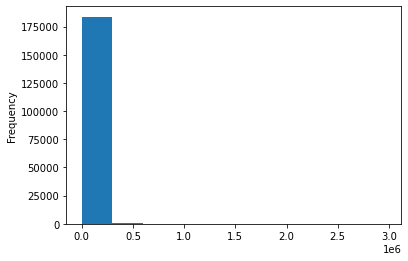

In [5]:
print(max(df['debt_to_equity']), min(df['debt_to_equity']))
df['ltq'].plot(kind='hist')
# Filter out rows with negative values in dlttq, seqq, or 0
filtered_df = df[(df['dlttq'] > 0) & (df['seqq'] > 0)]
filtered_df.head()
print(max(filtered_df['debt_to_equity']), min(filtered_df['debt_to_equity']))
filtered_df['debt_to_equity'].plot(kind='hist')
# truncating the ratio to only include rows under 100 (realistically we probably want an even lower ratio)
filtered_df = filtered_df[(filtered_df['debt_to_equity'] < 1000)]
print(max(filtered_df['debt_to_equity']), min(filtered_df['debt_to_equity']))
filtered_df['debt_to_equity'].plot(kind='hist')
filtered_df.tail()

In [6]:
returns_df = pd.read_sql_query('SELECT date,cusip,ticker,ret,prc,askhi,bidlo FROM returns', get_data.engine)
returns_df.head()

,date,cusip,ticker,ret,prc,askhi,bidlo
0,2019-06-28,89623910,TRMB,0.015762,45.11,45.24,44.49
1,2019-07-29,89623910,TRMB,-0.011376,44.32,44.96,44.25
2,2019-07-30,89623910,TRMB,0.002708,44.44,44.63,43.89
3,2019-07-31,89623910,TRMB,-0.049055,42.26,44.93,42.13
4,2019-08-28,89623910,TRMB,0.008018,36.46,36.73,35.86


11783960


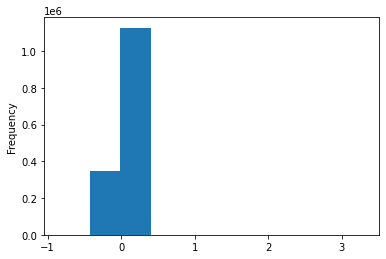

In [7]:
returns_df['ret'] = pd.to_numeric(returns_df['ret'], errors='coerce')
returns_df.dropna(subset=['ret'], inplace=True)
returns_df['ret'].plot(kind='hist')
returns_df['pct_change'] = returns_df['ret'].pct_change() / 100
returns_df['pct_change'] = scipy.stats.mstats.winsorize(returns_df['pct_change'], limits=[0.01, 0.01], axis=0, inplace=False, nan_policy='omit')
returns_df['pct_change'] = returns_df['pct_change'] + 1
returns_df.dropna(subset=['pct_change'], inplace=True)
returns_df.head()
print(returns_df.size)

In [8]:
print(returns_df['ticker'].nunique())

4093


In [9]:
returns_df['cum_return'] = returns_df.groupby('ticker')['pct_change'].cumprod()
print(returns_df.size)
returns_df.head()

13256955


,date,cusip,ticker,ret,prc,askhi,bidlo,pct_change,cum_return
1,2019-07-29,89623910,TRMB,-0.011376,44.32,44.960,44.25,0.982783,0.982783
2,2019-07-30,89623910,TRMB,0.002708,44.44,44.630,43.89,0.987620,0.970615
3,2019-07-31,89623910,TRMB,-0.049055,42.26,44.930,42.13,0.808852,0.785084
4,2019-08-28,89623910,TRMB,0.008018,36.46,36.730,35.86,0.988366,0.775950
5,2019-08-29,89623910,TRMB,0.029073,37.52,37.705,37.00,1.026260,0.796326


In [10]:
window = 90
returns_df = returns_df.drop_duplicates(subset=['date','ticker'], keep='first')
returns_df[f'rolling_ret_{window}'] = returns_df.groupby('ticker')['cum_return'].pct_change()
returns_df.head()


,date,cusip,ticker,ret,prc,askhi,bidlo,pct_change,cum_return,rolling_ret_90
1,2019-07-29,89623910,TRMB,-0.011376,44.32,44.960,44.25,0.982783,0.982783,NaN
2,2019-07-30,89623910,TRMB,0.002708,44.44,44.630,43.89,0.987620,0.970615,-0.012380
3,2019-07-31,89623910,TRMB,-0.049055,42.26,44.930,42.13,0.808852,0.785084,-0.191148
4,2019-08-28,89623910,TRMB,0.008018,36.46,36.730,35.86,0.988366,0.775950,-0.011634
5,2019-08-29,89623910,TRMB,0.029073,37.52,37.705,37.00,1.026260,0.796326,0.026260


In [11]:
print(returns_df[returns_df['ticker'] == 'FHTX'])

              date     cusip ticker       ret    prc  askhi   bidlo  \
195473  2020-10-28  34417410   FHTX -0.055000  15.12  16.15  14.030   
195474  2020-10-29  34417410   FHTX  0.058201  16.00  16.39  15.000   
195475  2020-10-30  34417410   FHTX -0.001250  15.98  16.45  15.000   
195476  2020-11-30  34417410   FHTX -0.035800  20.20  20.97  18.730   
195477  2020-12-28  34417410   FHTX -0.080390  22.65  24.93  22.300   
...            ...       ...    ...       ...    ...    ...     ...   
195562  2023-11-28  34417410   FHTX -0.034483   4.20   4.29   4.170   
195563  2023-11-29  34417410   FHTX -0.019048   4.12   4.28   4.010   
195564  2023-11-30  34417410   FHTX  0.031553   4.25   4.26   4.060   
195565  2023-12-28  34417410   FHTX  0.013493   6.76   6.77   6.520   
195566  2023-12-29  34417410   FHTX -0.045858   6.45   6.79   6.335   

        pct_change  cum_return  rolling_ret_90  
195473    1.004004    1.004004             NaN  
195474    0.979418    0.983339       -0.020582  


In [19]:
buy_trades, sell_trades = [] , []
for d in filtered_df['datadate'].unique():
  temp = filtered_df[filtered_df['datadate'] == d]
  quntile_nbr = int(len(temp) / 5.0)
  buy_trades.append(temp.sort_values('debt_to_equity', ascending=False).head(quntile_nbr))
  sell_trades.append(temp.sort_values('debt_to_equity', ascending=True).head(quntile_nbr))

df_buy_trades = pd.concat(buy_trades)
df_buy_trades['trade'] = 'buy'
df_sell_trades = pd.concat(sell_trades)
df_sell_trades['trade'] = 'sell'


df_buy_trades = df_buy_trades.drop_duplicates(subset=['datadate','tic'], keep='first')
df_sell_trades = df_sell_trades.drop_duplicates(subset=['datadate','tic'], keep='first')
print(df_buy_trades.size)
print(df_sell_trades.size)

239570
243410


<AxesSubplot:xlabel='datadate'>

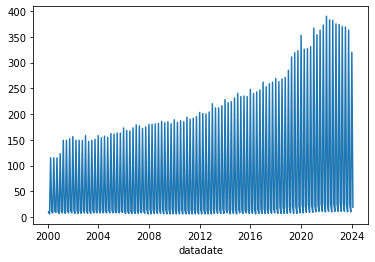

In [20]:
df_buy_trades.groupby('datadate')['tic'].size().plot(kind='line')

<AxesSubplot:xlabel='datadate'>

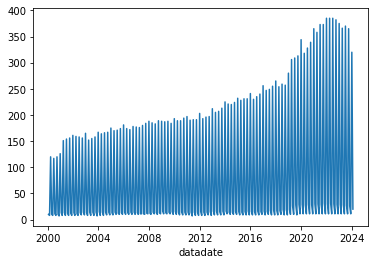

In [21]:
df_sell_trades.groupby('datadate')['cusip'].size().plot(kind='line')

In [22]:
returns_df['date'] = pd.to_datetime(returns_df['date'])
df_buy_trades['datadate'] = pd.to_datetime(df_buy_trades['datadate'])
df_sell_trades['datadate'] = pd.to_datetime(df_sell_trades['datadate'])

df_buy_trades = df_buy_trades.sort_values(by='datadate')
df_sell_trades = df_sell_trades.sort_values(by='datadate')
returns_df = returns_df.sort_values(by='date')

print(returns_df['ticker'].unique())

['RUSH' 'FCX' 'PDM' ... 'VYX' 'TRML' 'BYON']


In [23]:
merged_buy_analysis = pd.merge(df_buy_trades, returns_df, left_on=['datadate', 'tic'], right_on=['date', 'ticker'], how='left')
merged_buy_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_buy_analysis = merged_buy_analysis.dropna(subset=['rolling_ret_90'])
print(merged_buy_analysis.tail())

merged_sell_analysis = pd.merge(df_sell_trades, returns_df, left_on=['datadate', 'tic'], right_on=['date', 'ticker'], how='left')
merged_sell_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_sell_analysis = merged_sell_analysis.dropna(subset=['rolling_ret_90'])
print(merged_sell_analysis.tail())

# # Concatenate buy and sell trades
all_trades = pd.concat([merged_buy_analysis, merged_sell_analysis])
all_trades.reset_index(drop=True, inplace=True)
all_trades['rolling_ret_90'] = all_trades['rolling_ret_90'].clip(lower=-1, upper=1)


        datadate   gvkey   tic    cusip_x      dlttq       lseq       seqq  \
23206 2023-07-31  039310  VSCO  926400102   2555.000   4525.000    279.000   
23210 2023-08-31  011264   WBA  931427108  31187.000  96628.000  20020.000   
23589 2023-10-31  033718    BJ  05550J101   2483.099   6837.244   1353.696   
23592 2023-10-31  039310  VSCO  926400102   2809.000   4687.000    220.000   
23598 2023-10-31  170616  SPLK  848637104   3261.761   5391.780    198.885   

             ltq  debt_to_equity trade  ...   cusip_y ticker       ret  \
23206   4225.000        9.157706   buy  ...  92640010   VSCO  0.015865   
23210  68139.000        1.557792   buy  ...  93142710    WBA -0.011328   
23589   5483.548        1.834311   buy  ...  05550J10     BJ -0.009164   
23592   4449.000       12.768182   buy  ...  92640010   VSCO  0.032333   
23598   5192.895       16.400236   buy  ...  84863710   SPLK -0.000272   

          prc   askhi    bidlo  pct_change  cum_return  rolling_ret_90  \
23206   20.4

In [24]:
fig = px.box(all_trades, x='trade', y='rolling_ret_90')
fig.show()

In [25]:
returns_df['pct_change_shift_neg1'] = returns_df.groupby('ticker')['pct_change'].shift(-1)
reduced_returns_df = returns_df[['date', 'ticker', 'pct_change_shift_neg1']]
reduced_returns_df.dropna(inplace=True)
print(reduced_returns_df.tail())

              date ticker  pct_change_shift_neg1
1429925 2023-12-28    TLS               1.070419
1072396 2023-12-28   RGEN               0.956458
1272540 2023-12-28  SENEA               0.971674
823851  2023-12-28   NNOX               0.957893
583030  2023-12-28    AMD               0.985072


<ipython-input-25-a633344de730>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
all_trades_analysis = pd.concat([df_buy_trades, df_sell_trades])

# Creating 'trade_dir' column based on the 'trade' column
all_trades_analysis['trade_dir'] = np.where(all_trades_analysis['trade'] == 'buy', 1, -1)

# Printing the head of all_trades_analysis
print(all_trades_analysis.head())

         datadate   gvkey   tic      cusip    dlttq     lseq     seqq  \
123212 2000-01-31  013602  CRMT  03062T105  179.212  270.374   57.047   
140914 2000-01-31  065702  CWST  147448104  374.126  757.295  269.261   
20268  2000-01-31  025130   CNR  21925D109  411.649  848.349  279.501   
140816 2000-01-31  065640   CSR  15202L107  245.991  389.606  107.330   
160658 2000-01-31  005109   GCO  371532102  103.500  301.165  108.242   

            ltq  debt_to_equity trade  trade_dir  
123212  208.894        3.141480   buy          1  
140914  488.034        1.389455   buy          1  
20268   568.848        1.472800   buy          1  
140816  251.232        2.291913   buy          1  
160658  192.923        0.956191   buy          1  


In [32]:
reduced_returns_df = reduced_returns_df.sort_values(by='date')
all_trades_analysis = all_trades_analysis.sort_values(by='datadate')
trade_df = pd.merge(all_trades_analysis, reduced_returns_df, how="left", left_on=["datadate", "tic"], right_on=["date","ticker"])
trade_df.dropna(inplace=True)
print(trade_df)

        datadate   gvkey   tic      cusip     dlttq       lseq       seqq  \
1     2000-01-31  004016    DG  256677105     1.200   1450.941    925.921   
2     2000-01-31  019402  GIII  36237H101     0.064     59.601     41.033   
3     2000-01-31  002352   BRC  104674106     1.009    356.142    275.733   
4     2000-01-31  001632   ADI  032654105    13.218   2489.333   1746.345   
5     2000-01-31  117768  NVDA  67066G104     0.962    202.250    124.563   
...          ...     ...   ...        ...       ...        ...        ...   
47614 2023-11-30  009466  SCHL  807066105    84.100   1833.500   1079.100   
47615 2023-11-30  264387  ANGO  03475V101     2.568    499.623    401.226   
47616 2023-11-30  008348   PKE  70014A104     0.094    127.507    111.985   
47617 2023-11-30  064929   SLP  829214105     0.669    185.778    172.341   
47618 2023-11-30  143357   ACN  G1151C101  2291.775  51531.354  26676.751   

             ltq  debt_to_equity trade  trade_dir       date ticker  \
1   

In [37]:
trade_df.head()

,datadate,gvkey,tic,cusip,dlttq,lseq,seqq,ltq,debt_to_equity,trade,trade_dir,date,ticker,pct_change_shift_neg1
1,2000-01-31,004016,DG,256677105,1.200,1450.941,925.921,525.020,0.001296,sell,-1,2000-01-31,DG,1.012299
2,2000-01-31,019402,GIII,36237H101,0.064,59.601,41.033,18.568,0.001560,sell,-1,2000-01-31,GIII,0.990000
3,2000-01-31,002352,BRC,104674106,1.009,356.142,275.733,80.409,0.003659,sell,-1,2000-01-31,BRC,0.993065
4,2000-01-31,001632,ADI,032654105,13.218,2489.333,1746.345,742.988,0.007569,sell,-1,2000-01-31,ADI,1.012639
5,2000-01-31,117768,NVDA,67066G104,0.962,202.250,124.563,77.687,0.007723,sell,-1,2000-01-31,NVDA,0.998552


    datadate   gvkey   tic      cusip   dlttq      lseq      seqq      ltq  \
1 2000-01-31  004016    DG  256677105   1.200  1450.941   925.921  525.020   
2 2000-01-31  019402  GIII  36237H101   0.064    59.601    41.033   18.568   
3 2000-01-31  002352   BRC  104674106   1.009   356.142   275.733   80.409   
4 2000-01-31  001632   ADI  032654105  13.218  2489.333  1746.345  742.988   
5 2000-01-31  117768  NVDA  67066G104   0.962   202.250   124.563   77.687   

   debt_to_equity trade  trade_dir       date ticker  pct_change_shift_neg1  \
1        0.001296  sell         -1 2000-01-31     DG               1.012299   
2        0.001560  sell         -1 2000-01-31   GIII               0.990000   
3        0.003659  sell         -1 2000-01-31    BRC               0.993065   
4        0.007569  sell         -1 2000-01-31    ADI               1.012639   
5        0.007723  sell         -1 2000-01-31   NVDA               0.998552   

   cumulative_return  
1           2.012299  
2         

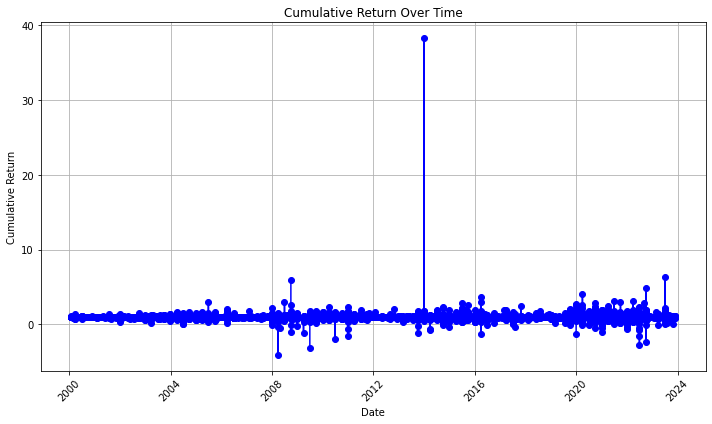

In [42]:
trade_df['cumulative_return'] = (1 + trade_df['pct_change_shift_neg1']).cumprod()
print(trade_df.head())
# Step 2: Plot Line Graph
plt.figure(figsize=(10, 6))
plt.plot(trade_df['date'], trade_df['pct_change_shift_neg1'], color='blue', marker='o', linestyle='-')
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()